# Profile extraction and reconstruction from REHO

In [444]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF
import seaborn as sns
import html5lib

import reho.plotting.yearly_profile_builder
from reho.model.reho import *
from reho.plotting.plotting import temperature_profile

Helper functions

In [445]:
def parse_energyplus_datetime_string(st, year=2005):
    st = st.strip()
    month = int(st[0:2])
    day = int(st[3:5])
    hour = int(st[7:9])
    minute = int(st[10:12])
    second = (st[13:15])
    if not hour == 24:
        dt = pd.Timestamp(year, month, day, hour, minute)
    else:
        hour = 0
        dt = pd.Timestamp(year, month, day, hour, minute)
        dt += pd.Timedelta('1 day')
    return dt

def extract_U_factor(results_path=r'output_data\idf1_tbl.htm'):
    # read EPlus results as html
    df = pd.read_html(results_path, header=0)
    # detect indices where "U-Factor" appears
    indices = []
    numerator = 0
    denominator = 0
    for idx, tables in enumerate(df):
        # Check if "U-factor" appears in the column names
        if any(isinstance(col, str) and 'U-Factor' in col for col in tables.columns):
            # If found, save the table index
            indices.append(idx)
    # extract summary table related to CELLS walls
    # !!! Hardcoded
    opaque_ext = pd.DataFrame(df[32])
    windows_ext = pd.DataFrame(df[34])

    # # recompute averaged U-factor for walls
    numerator = numerator + ((opaque_ext['U-Factor with Film [W/m2-K]'] * opaque_ext['Net Area [m2]']).sum())
    denominator = denominator + opaque_ext['Net Area [m2]'].sum()

    # recompute averaged U-factor for windows
    numerator = numerator + ((windows_ext['Glass U-Factor [W/m2-K]'] * windows_ext['Glass Area [m2]']).sum())
    denominator = denominator + windows_ext['Glass Area [m2]'].sum()
    
    U_factor = numerator / denominator
    # convert to W -> kW
    return U_factor / 1000, indices

def modify_setpoint(idf, new_setpoint, name_SIA, modified_hours=list(range(9, 18)), verbose='q'):
    for entity in idf.idfobjects:
        for field in idf.idfobjects[entity]:
            if 'Name' in field.objls:  # check field with names only
                if name_SIA in field.Name:  # modify fields where modified SIA file appears
                    for hours in modified_hours:
                        # if hours in modified_hours:
                        # Replace the value with new setpoint
                        setattr(field, f"Value_{hours}", new_setpoint)
                    if verbose != 'q':
                        print(field)

def modify_capacity(new_capacity):
    print(new_capacity)
    
def reconstruct_profile(df_results, profile):
    """
        return a df series of the selected profile
        one column per building
        TODO : check if multi-building is okay

        Author : Florent

        Parameters:
            df_results (df): dataframe of a scenario

        Returns:
            df_profile
    """
    # Extract the data
    buildings_list = list(df_results['df_Buildings'].index)
    df_buildings_t = df_results['df_Buildings_t']

    # Prepare the df to store the profiles
    df_profile = pd.DataFrame()

    # list of the two last periods used for design purpose to drop later
    period_to_drop = list(df_buildings_t.xs('Building1').index.get_level_values('Period').unique()[-2:])

    # For each building: calculation of the profile series
    for b in buildings_list:
        # Take Tin for the building in df_buildings_t
        df_profile_building = pd.DataFrame()
        df_profile_building[profile] = df_buildings_t.xs(b)[profile]

        # drop the last two periods for design
        for i in period_to_drop:
            df_profile_building = df_profile_building.drop(i, level='Period')

        # to averaging over days if wanted
        items_average = 24  # daily
        # array to work for a building
        profile_building = np.array([])

        for j in range(1, 366):
            id = df_results['df_Index'].PeriodOfYear[j * 24]
            data_id = df_profile_building.xs(id)
            profile_building = np.concatenate((profile_building, data_id[profile]))

        # to averaging over days if wanted
        # profile_building = np.mean(profile_building.reshape(-1, items_average), axis=1)

        # Store the data in df_profile (one col per building)
        df_profile[profile + str(b)] = profile_building

    # create idx
    idx = list(df_profile.index + 1)
    return df_profile.to_numpy(), idx

def rmse(true, pred):
    return np.sqrt(np.mean((true-pred)**2))

def mae(true, pred):
    return np.mean(np.abs(true-pred))

## Vanilla REHO optimization
Start by running an optimization with defaults parameters of REHO

In [446]:
# hardcoded base values for the buildings.csv file
data = {
    'area_era_m2': [53.91],
    'id_building': [1],
    'temperature_cooling_supply_C': [12],
    'temperature_cooling_return_C': [17],
    'temperature_heating_supply_C': [65],
    'temperature_heating_return_C': [50],
    'area_facade_m2': [72.07],
    'area_roof_solar_m2': [53.91],
    'temperature_interior_C': [21],
    'ratio': [1.0],
    'status': ['[existing]'],
    'id_class': ['III'],
    'solar_gain_factor_signature_m2': [0.07],  # not computed yet
    'thermal_specific_capacity_Wh_m2_K': [120],
    'thermal_transmittance_signature_kW_m2_K': [2/1000]
}

buildings = pd.DataFrame(data)
display(buildings)

,area_era_m2,id_building,temperature_cooling_supply_C,temperature_cooling_return_C,temperature_heating_supply_C,temperature_heating_return_C,area_facade_m2,area_roof_solar_m2,temperature_interior_C,ratio,status,id_class,solar_gain_factor_signature_m2,thermal_specific_capacity_Wh_m2_K,thermal_transmittance_signature_kW_m2_K
0,53.91,1,12,17,65,50,72.07,53.91,21,1.0,[existing],III,0.07,120,0.002


In [447]:
# Set building parameters
# you can as well define your district from a csv file instead of reading the database
reader = QBuildingsReader()
qbuildings_data = reader.read_csv(buildings_filename=r'.\data\buildings.csv', nb_buildings=1)

# Select weather data
cluster = {'Location': 'Fribourg', 'Attributes': ['I', 'T'], 'Periods': 10, 'PeriodDuration': 24}

# Set scenario
scenario = dict()
scenario['Objective'] = 'TOTEX'
scenario['name'] = 'totex'
scenario['exclude_units'] = ['Battery', 'NG_Cogeneration', 'PV']
scenario['enforce_units'] = []

# Initialize available units and grids
grids = infrastructure.initialize_grids()
units = infrastructure.initialize_units(scenario, grids)

# Set method options
method = {'building_scale' : True}

# Run optimization
reho_model = reho(qbuildings_data=qbuildings_data, units=units, grids=grids, cluster=cluster, scenario=scenario, method=method, solver="gurobiasl")

reho_model.parameters["Cooling"] = np.array([1.0])

reho_model.single_optimization()
reho_model.save_results(format=['xlsx', 'pickle'], filename='reho')

Key egid not in the dictionary
Key class not in the dictionary
Key period not in the dictionary
Key capita_cap not in the dictionary
Key height_m not in the dictionary
Key count_floor not in the dictionary
Key source_heating not in the dictionary
Key source_hotwater not in the dictionary
Key x not in the dictionary
Key y not in the dictionary
Key z not in the dictionary
Key geometry not in the dictionary
Key transformer not in the dictionary
Key energy_heating_signature_kWh_y not in the dictionary
Key energy_cooling_signature_kWh_y not in the dictionary
Key energy_hotwater_signature_kWh_y not in the dictionary
Key energy_el_kWh_y not in the dictionary
Key roof_annual_irr_kWh_y not in the dictionary
Key facade_annual_irr_kWh_y not in the dictionary
No geometry in the dataframe
Gurobi 11.0.0: optimal solution; objective 2013.317902
3258 simplex iterations
1 branch-and-cut nodes
plus 13876 simplex iterations for intbasis
              Costs_op  Costs_inv  ANN_factor  Costs_grid_connection

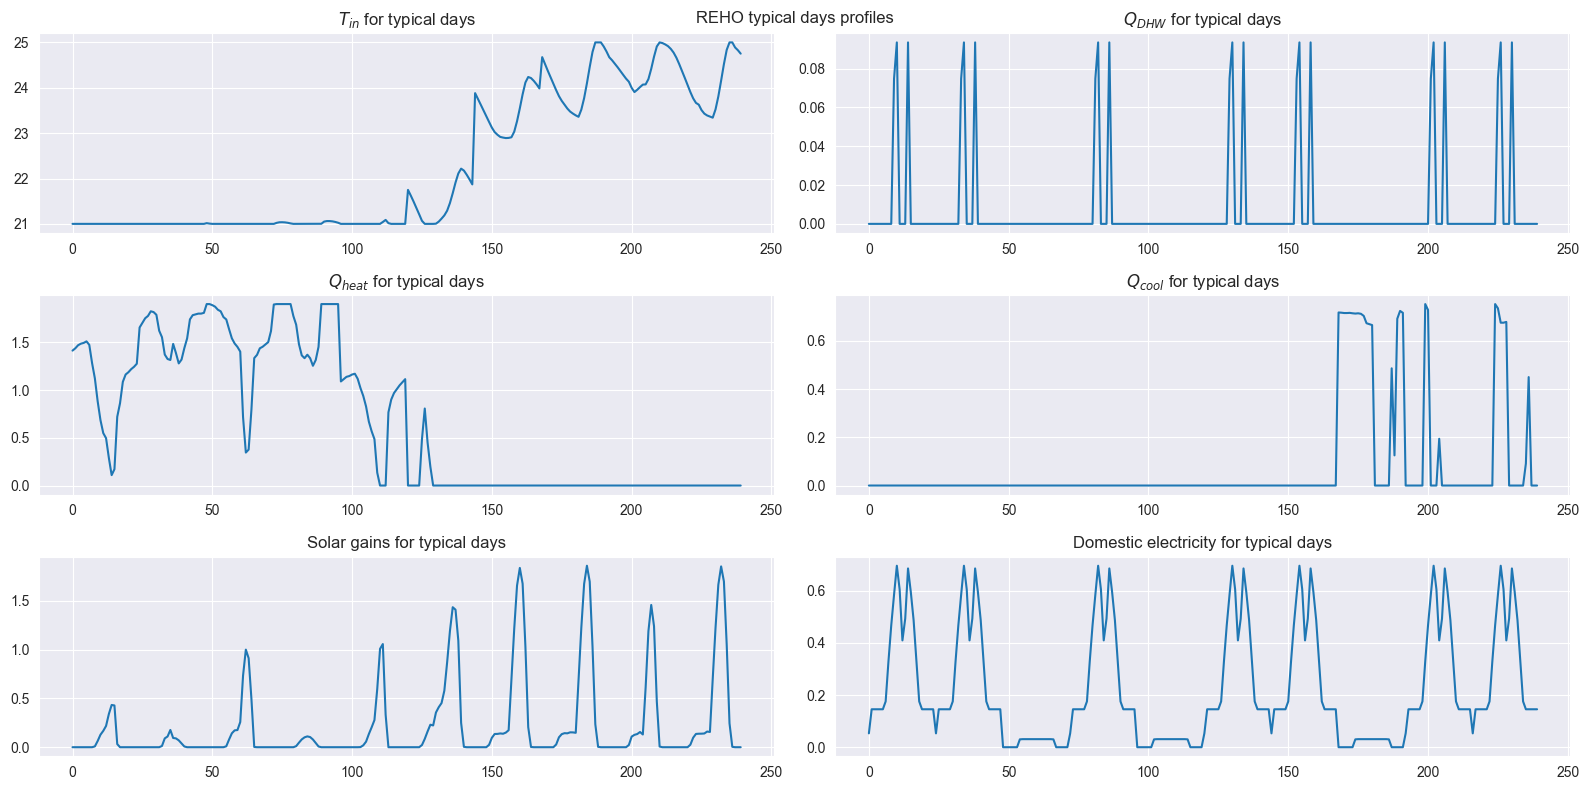

In [448]:
# Extract typical days profiles
T_in_typical = reho_model.results["totex"][0]["df_Buildings_t"]["T_in"].xs("Building1").values[0:-2]
Q_DHW_typical = reho_model.results["totex"][0]["df_Buildings_t"]["House_Q_DHW"].xs("Building1").values[0:-2]
Q_heating_typical = reho_model.results["totex"][0]["df_Buildings_t"]["House_Q_heating"].xs("Building1").values[0:-2]
Q_cooling_typical = reho_model.results["totex"][0]["df_Buildings_t"]["House_Q_cooling"].xs("Building1").values[0:-2]
Solar_gains_typical = reho_model.results["totex"][0]["df_Buildings_t"]["SolarGains"].xs("Building1").values[0:-2]
Domestic_electricity_typical = reho_model.results["totex"][0]["df_Buildings_t"]["Domestic_electricity"].xs("Building1").values[0:-2]

fig, ax = plt.subplots(3,2, figsize=(16,8))

ax[0][0].plot(T_in_typical)
ax[0][0].set_title('$T_{in}$ for typical days')

ax[0][1].plot(Q_DHW_typical)
ax[0][1].set_title('$Q_{DHW}$ for typical days')

ax[1][0].plot(Q_heating_typical)
ax[1][0].set_title('$Q_{heat}$ for typical days')

ax[1][1].plot(Q_cooling_typical)
ax[1][1].set_title('$Q_{cool}$ for typical days')

ax[2][0].plot(Solar_gains_typical)
ax[2][0].set_title('Solar gains for typical days')

ax[2][1].plot(Domestic_electricity_typical)
ax[2][1].set_title('Domestic electricity for typical days')

plt.tight_layout()
plt.suptitle('REHO typical days profiles')
plt.show()

In [449]:
reho_model.results["totex"][0]["df_Buildings_t"].columns;

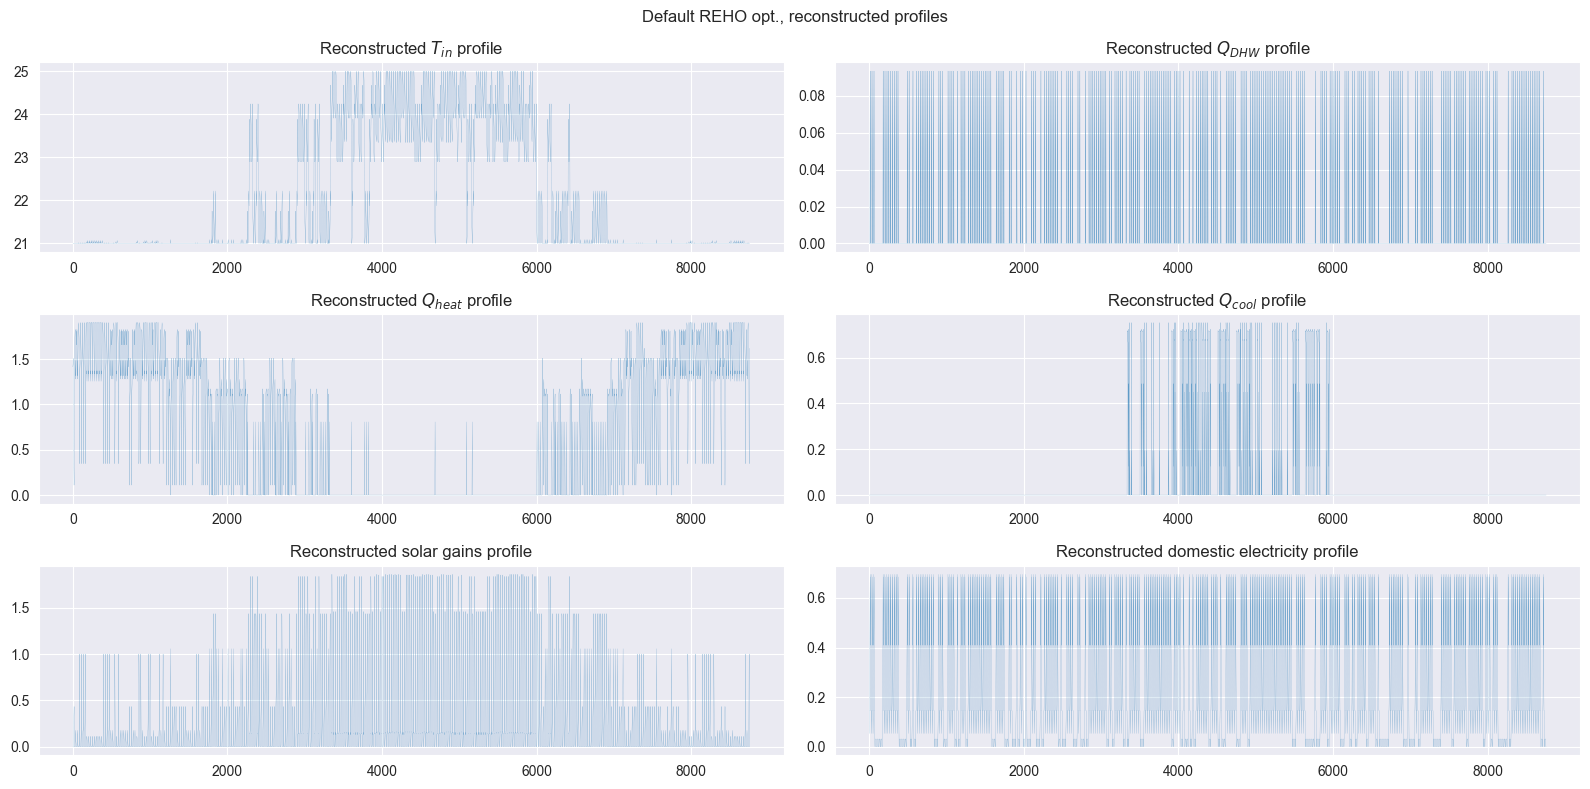

In [450]:
T_in_profile, _        = reconstruct_profile(reho_model.results['totex'][0],'T_in')
Q_DHW_profile, _       = reconstruct_profile(reho_model.results['totex'][0],'House_Q_DHW')
Q_heating_profile, _   = reconstruct_profile(reho_model.results['totex'][0],'House_Q_heating')
Q_cooling_profile, _   = reconstruct_profile(reho_model.results['totex'][0],'House_Q_cooling')
Solar_gains_profile, _ = reconstruct_profile(reho_model.results['totex'][0],'SolarGains')
Domestic_electricity_profile, _ = reconstruct_profile(reho_model.results['totex'][0],'Domestic_electricity')

fig, ax = plt.subplots(3,2, figsize=(16,8))

ax[0][0].plot(T_in_profile, lw=0.1)
ax[0][0].set_title('Reconstructed $T_{in}$ profile')

ax[0][1].plot(Q_DHW_profile,lw=0.1)
ax[0][1].set_title('Reconstructed $Q_{DHW}$ profile')

ax[1][0].plot(Q_heating_profile,lw=0.1)
ax[1][0].set_title('Reconstructed $Q_{heat}$ profile')

ax[1][1].plot(Q_cooling_profile,lw=0.1)
ax[1][1].set_title('Reconstructed $Q_{cool}$ profile')

ax[2][0].plot(Solar_gains_profile,lw=0.1)
ax[2][0].set_title('Reconstructed solar gains profile')

ax[2][1].plot(Domestic_electricity_profile,lw=0.1)
ax[2][1].set_title('Reconstructed domestic electricity profile')

plt.suptitle('Default REHO opt., reconstructed profiles')
plt.tight_layout()
plt.show()

## Run a base simulation with EnergyPlus


In [451]:
## Define the paths to the various inputs
# Specify path to the IDF file
idf_file_path = r".\input_data\CELLS.idf"

# Specify path to the IDD file
idd_file_path = r".\input_data\Energy+.idd" # Energy+ v9.4 IDD

# Specify path to the weather file
weather_file_path = r".\input_data\-_FRIBOURG_MN7.epw"

# Set the idd file
IDF.setiddname(idd_file_path)

# Create an IDF object and load the IDF file
idf = IDF(idf_file_path, weather_file_path)

# Specify path to the EnergyPlus results folder
idf_results_path = r".\output_data"
## Run base EnergyPlus simulation
# readvars = True creates a .cvs of the results
# annual = True forces the simulation to run on an annual basis

idf.run(readvars=True, output_directory=idf_results_path, annual=True, verbose='q', output_prefix='eplus_')

In [452]:
# load eplus_out.csv
eplus_results=pd.read_csv(r".\output_data\eplus_out.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )

### Temperature

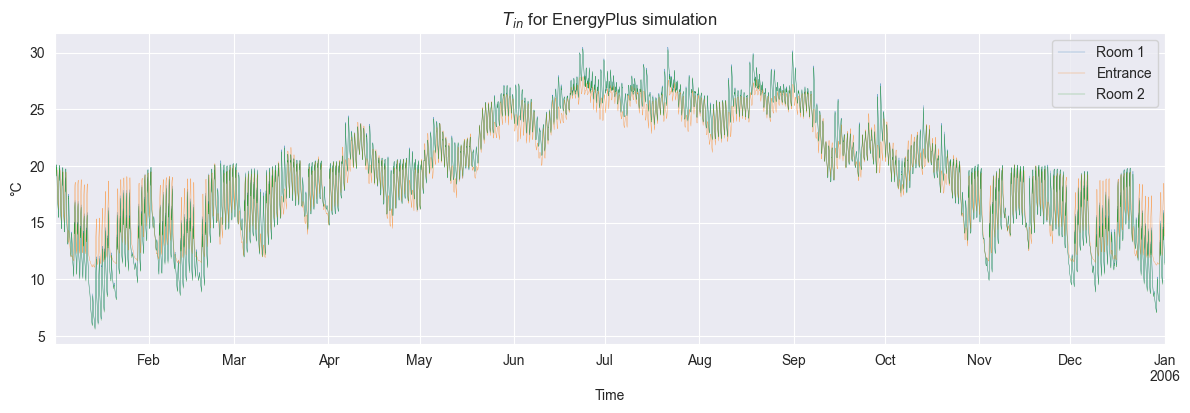

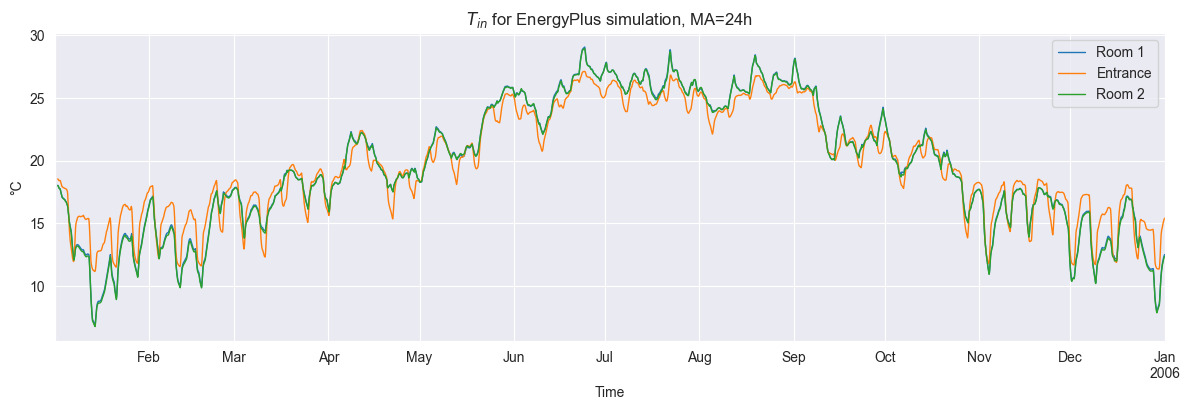

In [453]:
# Extract temperature profiles
operative_temperature = [col for col in eplus_results.columns if 'Operative' in col]
T_in_eplus = eplus_results[operative_temperature]

T_in_eplus.plot(kind='line', lw= 0.20, figsize=(12, 4))
plt.legend(["Room 1","Entrance", "Room 2"])
plt.xlabel('Time')
plt.ylabel('°C')
plt.tight_layout()
plt.title('$T_{in}$ for EnergyPlus simulation')

T_in_eplus.rolling(window=24).mean().plot(kind='line', lw= 1, figsize=(12, 4))
plt.legend(["Room 1","Entrance", "Room 2"])
plt.xlabel('Time')
plt.ylabel('°C')
plt.tight_layout()
plt.title('$T_{in}$ for EnergyPlus simulation, MA=24h')

plt.show()

In [454]:
##extract typical dates from the clustering
#load timestamps_Fribourg in data/clustering
timestamps_Fribourg = pd.read_table(r".\data\clustering\timestamp_Fribourg_10_24_T_I.dat",index_col=0)

#convert date to datetime
timestamps_Fribourg.index = pd.to_datetime(timestamps_Fribourg.index)
timestamps_Fribourg.index.name = 'Date/Time'
timestamps_Fribourg = timestamps_Fribourg[:-2] # drop the last two periods for design

# Filter eplus_results based on the dates in timestamps_Fribourg
eplus_results_typical = eplus_results[pd.to_datetime(eplus_results.index.date).isin(timestamps_Fribourg.index)]


MAE = 4.79 °C


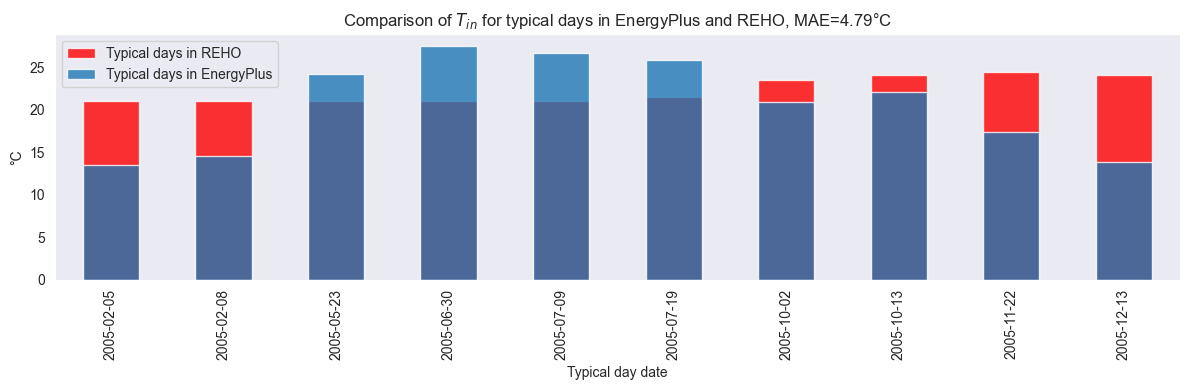

In [455]:
T_in_typical_df = pd.DataFrame(T_in_typical, index=eplus_results_typical.index)

#compute the mae for the typical days
T_in_mae = mae(eplus_results_typical['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'].groupby(eplus_results_typical.index.date).mean().values,T_in_typical_df.groupby(T_in_typical_df.index.date).mean().values)
print(f'MAE = {T_in_mae:.2f} °C')

T_in_typical_df.groupby(T_in_typical_df.index.date).mean().plot(kind='bar', color='r', alpha=0.8, figsize=(12, 4))
eplus_results_typical['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'].groupby(eplus_results_typical.index.date).mean().plot(kind='bar',alpha=0.8)
plt.legend(['Typical days in REHO', 'Typical days in EnergyPlus'])
plt.xlabel('Typical day date')
plt.ylabel('°C')
plt.title(f'Comparison of $T_{{in}}$ for typical days in EnergyPlus and REHO, MAE={T_in_mae:.2f}°C')
plt.tight_layout()
plt.grid()

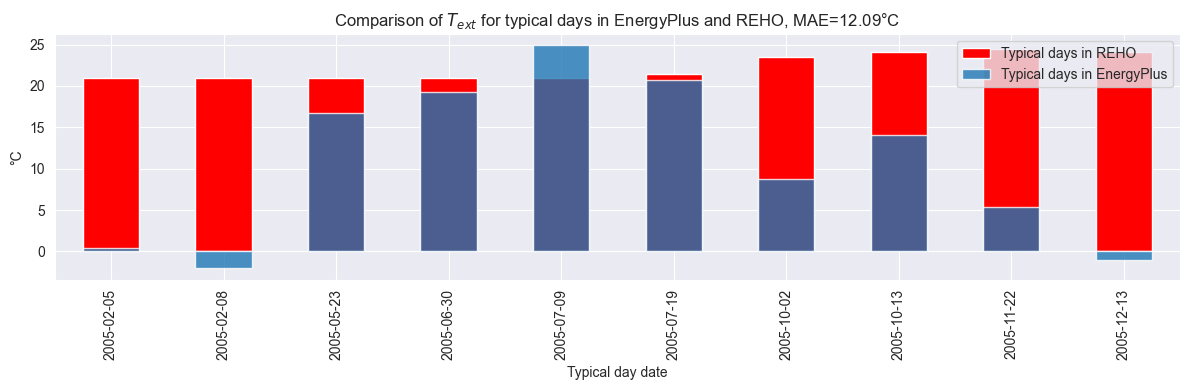

In [456]:
T_ext_typical = reho_model.results["totex"][0]["df_External"]['T_ext'].values[0:-2]
T_ext_typical = pd.DataFrame(T_in_typical, index=eplus_results_typical.index)

T_ext_mae = mae(eplus_results_typical['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)'].groupby(eplus_results_typical.index.date).mean().values,T_ext_typical.groupby(T_ext_typical.index.date).mean().values)

T_ext_typical.groupby(T_ext_typical.index.date).mean().plot(kind='bar', color='r')
eplus_results_typical['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)'].groupby(eplus_results_typical.index.date).mean().plot(kind='bar',alpha=0.8, figsize=(12, 4))
plt.legend(['Typical days in REHO', 'Typical days in EnergyPlus'])
plt.xlabel('Typical day date')
plt.ylabel('°C')
plt.title(f'Comparison of $T_{{ext}}$ for typical days in EnergyPlus and REHO, MAE={T_ext_mae:.2f}°C')
plt.tight_layout()

### Solar gains

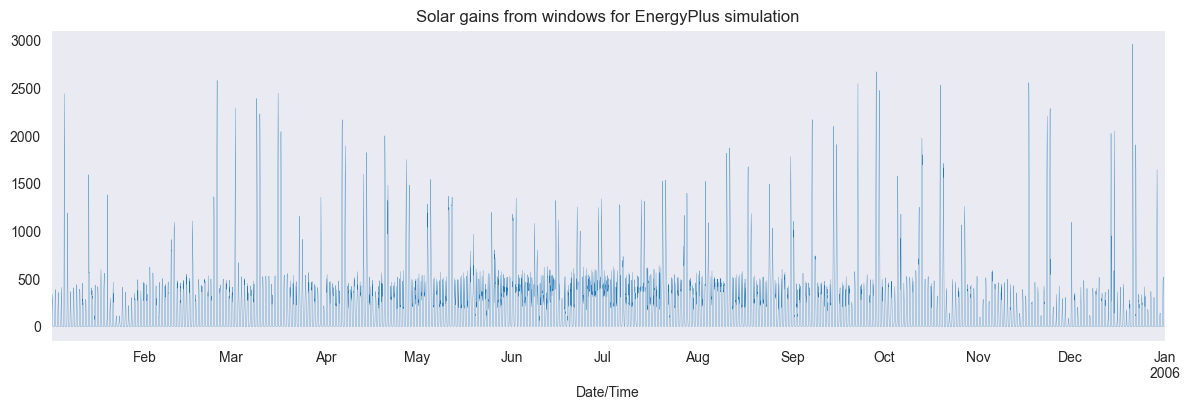

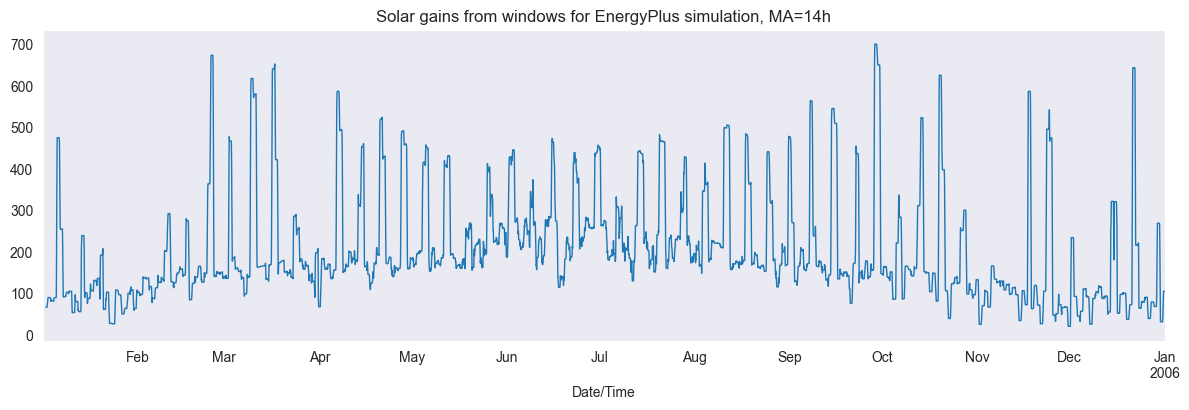

In [457]:
windows_solar_gains = [col for col in eplus_results.columns if 'Windows Total Transmitted Solar' in col]

Solar_gains_eplus = eplus_results[windows_solar_gains]

Solar_gains_eplus.sum(axis=1).plot(kind='line', lw= 0.20, figsize=(12, 4))
plt.tight_layout()
plt.title('Solar gains from windows for EnergyPlus simulation')
plt.grid()
plt.show()

Solar_gains_eplus.sum(axis=1).rolling(window=24).mean().plot(kind='line', lw= 1, figsize=(12, 4))
plt.tight_layout()
plt.title('Solar gains from windows for EnergyPlus simulation, MA=14h')
plt.grid()
plt.show()

## Vanilla Eplus and REHO profile comparison

### Temperature profiles

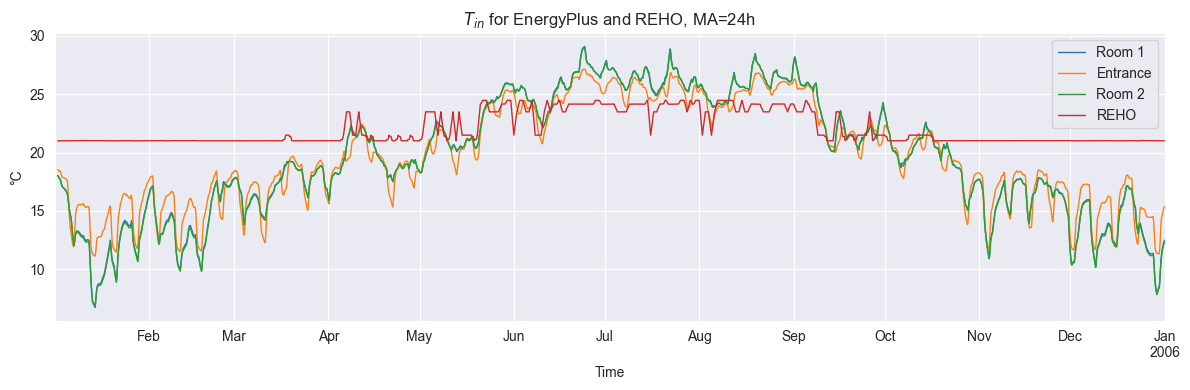

RMSE = 4.951167002919113


In [458]:
T_in_reho = pd.Series(T_in_profile.flatten(), index=T_in_eplus.index)

T_in_eplus.rolling(window=24).mean().plot(kind='line', lw= 1, figsize=(12, 4))
T_in_reho.rolling(window=24).mean().plot(kind='line', lw= 1)
plt.legend(["Room 1","Entrance", "Room 2","REHO"])
plt.xlabel('Time')
plt.ylabel('°C')
plt.title('$T_{in}$ for EnergyPlus and REHO, MA=24h')
plt.tight_layout()

plt.show()

T_in_error = rmse(T_in_eplus['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'],T_in_reho)
print(f'RMSE = {T_in_error}')

## Temperature profile adaptation
The temperature profile in REHO leads to high RMSE since by design EPlus activates the HVAC only during occupancy time. Relaxing the heating schedule on EPlus to match the REHO profile should lead to a better match.

In [459]:
new_setpoint = 21
SIA_heating_schedule = '10003_-50_12_21'
SIA_cooling_schedule = '10003_100_28_26'
SIA_heating_schedule_off = '11_-50_12_21'
SIA_cooling_schedule_off = '11_100_28_26'

modify_setpoint(idf, new_setpoint, SIA_heating_schedule, modified_hours=list(range(1, 25)), verbose='q')
modify_setpoint(idf, new_setpoint, SIA_cooling_schedule, modified_hours=list(range(1, 25)), verbose='q')

for entity in idf.idfobjects:
    for field in idf.idfobjects[entity]:
        if 'Name' in field.objls:  # check field with names only
            if SIA_heating_schedule_off in field.Name:  # modify fields where modified SIA file appears
                field.Value_Until_Time_1 = new_setpoint
                   
for entity in idf.idfobjects:
    for field in idf.idfobjects[entity]:
        if 'Name' in field.objls:  # check field with names only
            if SIA_cooling_schedule_off in field.Name:  # modify fields where modified SIA file appears
                field.Value_Until_Time_1 = new_setpoint

In [460]:
idf.run(readvars=True, output_directory=idf_results_path, annual=True, verbose='q', output_prefix='eplus_T')

In [461]:
eplus_results=pd.read_csv(r".\output_data\eplus_Tout.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )

In [462]:
operative_temperature.remove('CELLS:ENTRANCE:Zone Operative Temperature [C](Hourly:ON)')

In [463]:
reho_model.parameters["T_comfort_min_0"] = np.array([18] * 1)
reho_model.parameters["T_comfort_max_0"] = np.array([25] * 1)
reho_model.single_optimization()

# reconstruct profile
T_in_profile, _      = reconstruct_profile(reho_model.results['totex'][0],'T_in')
T_in_reho = pd.Series(T_in_profile.flatten(), index = T_in_eplus.index)

Gurobi 11.0.0: optimal solution; objective 1829.436273
3641 simplex iterations
1 branch-and-cut nodes
plus 11279 simplex iterations for intbasis
              Costs_op   Costs_inv  ANN_factor  Costs_grid_connection  \
Hub                                                                     
Building1  1449.752895  379.679652    0.061157                    0.0   
Network    1449.752895  379.679652    0.061157                    0.0   

           Costs_rep  Costs_ft       GWP_op  GWP_constr  EMOO_CAPEX  \
Hub                                                                   
Building1        0.0         0  1483.453849   15.245944         NaN   
Network          0.0         0  1483.453849   15.245944         0.0   

           EMOO_OPEX  EMOO_TOTEX  EMOO_GWP  EMOO_grid    Objective  
Hub                                                                 
Building1        NaN         NaN       NaN        NaN          NaN  
Network          0.0         0.0       0.0        0.0  1829.436273  
 

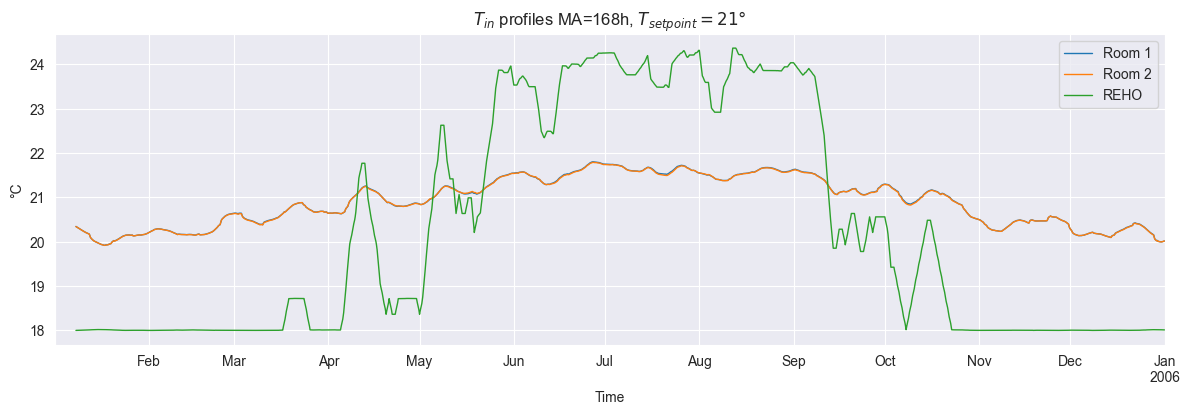

RMSE = 2.3411514042057515


In [464]:
T_in_eplus = eplus_results[operative_temperature]
T_in_eplus.rolling(window=168).mean().plot(kind='line', lw=1, figsize=(12, 4))
T_in_reho.rolling(window=168).mean().plot(kind='line', lw=1)
plt.legend(["Room 1", "Room 2", "REHO"])
plt.xlabel('Time')
plt.ylabel('°C')
plt.tight_layout()
plt.title(f'$T_{{in}}$ profiles MA=168h, $T_{{setpoint}}={new_setpoint}°$')

plt.show()

T_in_error = rmse(T_in_eplus['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'],T_in_reho)
print(f'RMSE = {T_in_error}')

In [465]:
# for n in range(10,20):
#     T_in_eplus.iloc[n*24:(n+1)*24].plot(kind='line', lw= 1, figsize=(12, 4))
#     T_in_reho.iloc[n*24:(n+1)*24].plot(kind='line', lw= 1)
#     plt.legend(["Room 1","Entrance", "Room 2","REHO"])
#     plt.xlabel('Time')
#     plt.ylabel('°C')
#     plt.title('$T_{in}$ for EnergyPlus and REHO, zoom on a day')
#     plt.tight_layout()
#     plt.show()

## Solar gains

In [466]:
Solar_gains_eplus.sum(axis=1)

Date/Time
2005-01-01 01:00:00    0.0
2005-01-01 02:00:00    0.0
2005-01-01 03:00:00    0.0
2005-01-01 04:00:00    0.0
2005-01-01 05:00:00    0.0
                      ... 
2005-12-31 20:00:00    0.0
2005-12-31 21:00:00    0.0
2005-12-31 22:00:00    0.0
2005-12-31 23:00:00    0.0
2006-01-01 00:00:00    0.0
Length: 8760, dtype: float64

In [467]:
Solar_gains_reho

Date/Time
2002-01-01 01:00:00    0.0
2002-01-01 02:00:00    0.0
2002-01-01 03:00:00    0.0
2002-01-01 04:00:00    0.0
2002-01-01 05:00:00    0.0
                      ... 
2002-12-31 20:00:00    0.0
2002-12-31 21:00:00    0.0
2002-12-31 22:00:00    0.0
2002-12-31 23:00:00    0.0
2003-01-01 00:00:00    0.0
Length: 8760, dtype: float64

Total Solar gains:  Eplus = 1791566.91 	 REHO = 1857132.92
RMSE = 440.1774859103609
Absolute total error = 3.66 %.


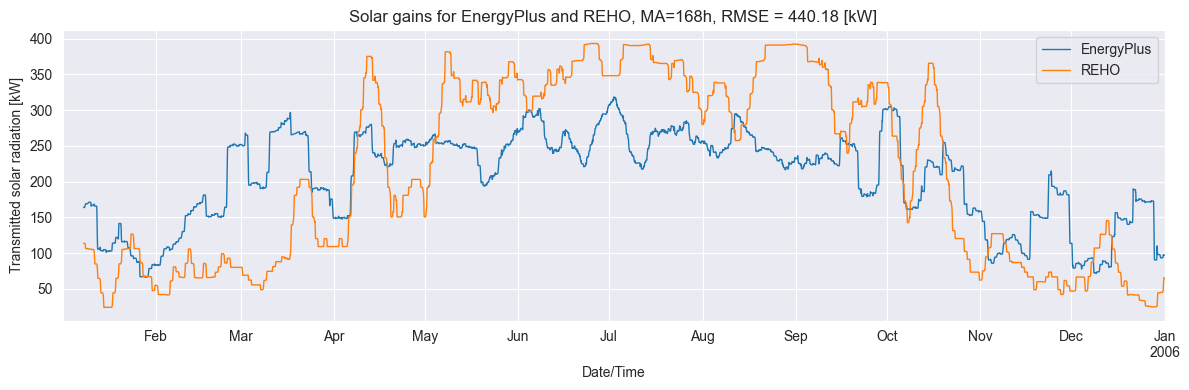

In [468]:
T = 168
Solar_gains_reho = pd.Series(Solar_gains_profile.flatten()*1000, index=Solar_gains_eplus.index)
Solar_gains_rmse = rmse(Solar_gains_eplus.sum(axis=1).values, Solar_gains_reho.values)

print(f'Total Solar gains:  Eplus = {Solar_gains_eplus.sum().sum():.2f} \t REHO = {Solar_gains_reho.sum():.2f}')
print(f'RMSE = {Solar_gains_rmse}')
print(f'Absolute total error = {(np.abs(Solar_gains_eplus.sum().sum() -Solar_gains_reho.sum()))/Solar_gains_eplus.sum().sum()*100:.2f} %.')

Solar_gains_eplus.sum(axis=1).rolling(window=T).mean().plot(kind='line', lw= 1, figsize=(12, 4))
Solar_gains_reho.rolling(window=T).mean().plot(kind='line', lw= 1)
plt.legend(["EnergyPlus","REHO"])
plt.ylabel('Transmitted solar radiation [kW]')

plt.title(f'Solar gains for EnergyPlus and REHO, MA={T}h, RMSE = {Solar_gains_rmse:.2f} [kW]')
plt.tight_layout()
plt.show()

## U-Factor correction

In order to test the model, we'd like to try to input the calculated value of $U$ by EPlus in REHO. This can is done by extracting every individual U for the envelope and recomputing a global value. For this step, only the envelope is considered, i.e the external walls, the windows, the roof and the ground.

### Modify material properties to alter U-Values

In [469]:
## helper function to access thickness or conductivity properties
def modify_material_properties(idf, material_name, property_name, property_value, field_name=None):
    material_list = ['EPS Expanded Polystyrene (Standard)_.18', 'Plywood (Heavyweight)_.14', 'MW Glass Wool (standard board)_.35', 'XPS Extruded Polystyrene  - CO2 Blowing_.18']
    window_list = ['Simple SLL_Triple_Glazing_601_SHGC_0.5_LT_0.75_U_0.6 - 1001']
    
    if not field_name:
        if material_name in material_list :
            field = 'MATERIAL'
        elif material_name in window_list:
            field = 'WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM'
        else:
            field = None
    else:
        field = field_name
        
    if field:
        for entity  in idf.idfobjects[field]:
            if 'Name' in entity.fieldnames and material_name == entity.Name: # check field with names only
                setattr(entity, property_name, property_value)

In [470]:
## define function to explore the impact of thickness on U-factor
def explore_UFactor(d_EPS,d_Wood,d_GWool,d_XPS,U_windows):
    # Material related to external wall
    EPS_name = "EPS Expanded Polystyrene (Standard)_.18"
    Wood_name = "Plywood (Heavyweight)_.14"
    
    modify_material_properties(idf, EPS_name, 'Thickness', d_EPS)
    modify_material_properties(idf, Wood_name, 'Thickness', d_Wood)
    
    # Material related to external floor
    GWool_name = "MW Glass Wool (standard board)_.35"
    
    modify_material_properties(idf, GWool_name, 'Thickness', d_GWool)
    
    # Material related to roof
    XPS_name = "XPS Extruded Polystyrene  - CO2 Blowing_.18"
    
    modify_material_properties(idf, XPS_name, 'Thickness', d_XPS)
    
    # Change windows U-values
    modify_material_properties(idf, 'Simple SLL_Triple_Glazing_601_SHGC_0.5_LT_0.75_U_0.6 - 1001', 'UFactor', U_windows )
    
    idf.run(readvars=True, output_directory=idf_results_path, annual=True, verbose='q', output_prefix='eplus_U')
    UFactor, _ = extract_U_factor(results_path=r'output_data\eplus_Utbl.htm')
    return UFactor

In [471]:
thickness_EPS    = [0.18, 0.10, 0.010, 0.001, 0.0001]
thickness_Wood   = [0.14, 0.10, 0.010, 0.001, 0.0001]
thickness_GWool  = [0.35, 0.20, 0.010, 0.001, 0.0001]
thickness_XPS    = [0.18, 0.10, 0.010, 0.001, 0.0001]
windows_U_factor = [0.60, 1.20, 1.60 , 2.6,   6]
U_factor         = np.zeros(5)
for i in range(len(thickness_EPS)):
    U_factor[i] = explore_UFactor(thickness_EPS[i],thickness_Wood[i],thickness_GWool[i],thickness_XPS[i],windows_U_factor[i])
    print(f'For d_Wood={thickness_Wood[i]}, d_EPS={thickness_EPS[i]}, d_GWool={thickness_GWool[i]}, d_XPS={thickness_XPS[i]} and windows_U={windows_U_factor[i]} --->\t U = {U_factor[i]*1000:.2f}')


For d_Wood=0.14, d_EPS=0.18, d_GWool=0.35, d_XPS=0.18 and windows_U=0.6 --->	 U = 0.18
For d_Wood=0.1, d_EPS=0.1, d_GWool=0.2, d_XPS=0.1 and windows_U=1.2 --->	 U = 0.32
For d_Wood=0.01, d_EPS=0.01, d_GWool=0.01, d_XPS=0.01 and windows_U=1.6 --->	 U = 1.18
For d_Wood=0.001, d_EPS=0.001, d_GWool=0.001, d_XPS=0.001 and windows_U=2.6 --->	 U = 1.82
For d_Wood=0.0001, d_EPS=0.0001, d_GWool=0.0001, d_XPS=0.0001 and windows_U=6 --->	 U = 2.18


In [472]:
# input it in reho
reho_model.buildings_data['Building1']['U_h'] = U_factor[-2]

# rerun optimization
reho_model.single_optimization()

Gurobi 11.0.0: optimal solution; objective 2011.745814
3653 simplex iterations
1 branch-and-cut nodes
plus 8796 simplex iterations for intbasis
              Costs_op   Costs_inv  ANN_factor  Costs_grid_connection  \
Hub                                                                     
Building1  1630.612695  381.128839    0.061157                    0.0   
Network    1630.612695  381.128839    0.061157                    0.0   

           Costs_rep  Costs_ft      GWP_op  GWP_constr  EMOO_CAPEX  EMOO_OPEX  \
Hub                                                                             
Building1        0.0         0  1786.27052   15.509625         NaN        NaN   
Network          0.0         0  1786.27052   15.509625         0.0        0.0   

           EMOO_TOTEX  EMOO_GWP  EMOO_grid    Objective  
Hub                                                      
Building1         NaN       NaN        NaN          NaN  
Network           0.0       0.0        0.0  2011.745814  
      

In [473]:
eplus_results = pd.read_csv(r".\output_data\eplus_Uout.csv",
                            parse_dates=[0],
                            index_col=[0],
                            date_parser=parse_energyplus_datetime_string)

T_in_eplus = eplus_results[operative_temperature]
T_in_profile, _      = reconstruct_profile(reho_model.results['totex'][0],'T_in')
T_in_reho = pd.Series(T_in_profile.flatten(), index=T_in_eplus.index)

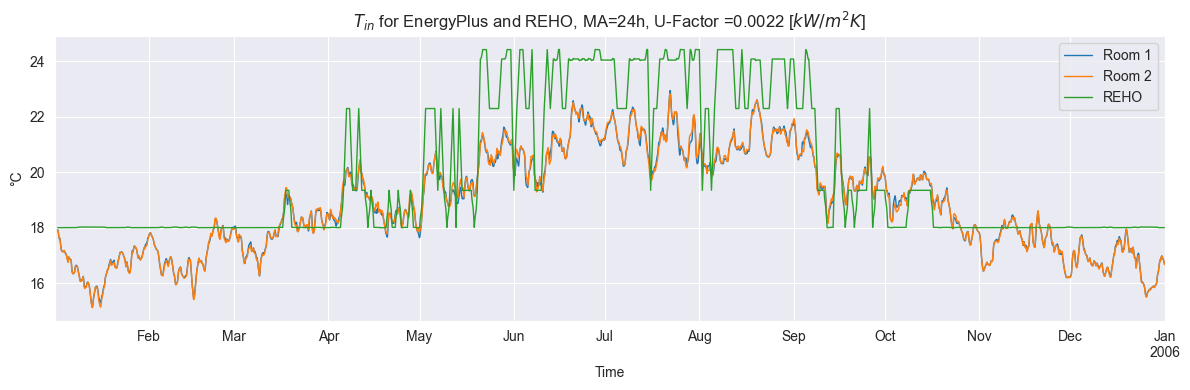

RMSE = 2.0027858062905923


In [474]:
T = 24
T_in_eplus.rolling(window=T).mean().plot(kind='line', lw= 1, figsize=(12, 4))
T_in_reho.rolling(window=T).mean().plot(kind='line', lw= 1)
plt.legend(["Room 1", "Room 2","REHO"])
plt.xlabel('Time')
plt.ylabel('°C')
plt.title(f'$T_{{in}}$ for EnergyPlus and REHO, MA={T}h, U-Factor ={U_factor[-1]:.4f} [$kW/m^2K$]')
plt.tight_layout()

plt.show()

T_in_error = rmse(T_in_eplus['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'],T_in_reho)
print(f'RMSE = {T_in_error}')

In [475]:
new_setpoint = 23
SIA_heating_schedule = '10003_-50_12_21'
SIA_cooling_schedule = '10003_100_28_26'
SIA_heating_schedule_off = '11_-50_12_21'
SIA_cooling_schedule_off = '11_100_28_26'

modify_setpoint(idf, new_setpoint, SIA_heating_schedule, modified_hours=list(range(1, 25)), verbose='q')
modify_setpoint(idf, new_setpoint, SIA_cooling_schedule, modified_hours=list(range(1, 25)), verbose='q')

for entity in idf.idfobjects:
    for field in idf.idfobjects[entity]:
        if 'Name' in field.objls:  # check field with names only
            if SIA_heating_schedule_off in field.Name:  # modify fields where modified SIA file appears
                field.Value_Until_Time_1 = new_setpoint
                   
for entity in idf.idfobjects:
    for field in idf.idfobjects[entity]:
        if 'Name' in field.objls:  # check field with names only
            if SIA_cooling_schedule_off in field.Name:  # modify fields where modified SIA file appears
                field.Value_Until_Time_1 = new_setpoint


In [476]:
idf.run(readvars=True, output_directory=idf_results_path, annual=True, verbose='q', output_prefix='eplus_U')

In [477]:
eplus_results=pd.read_csv(r".\output_data\eplus_Uout.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )

In [478]:
operative_temperature.remove('CELLS:ENTRANCE:Zone Operative Temperature [C](Hourly:ON)')

ValueError: list.remove(x): x not in list

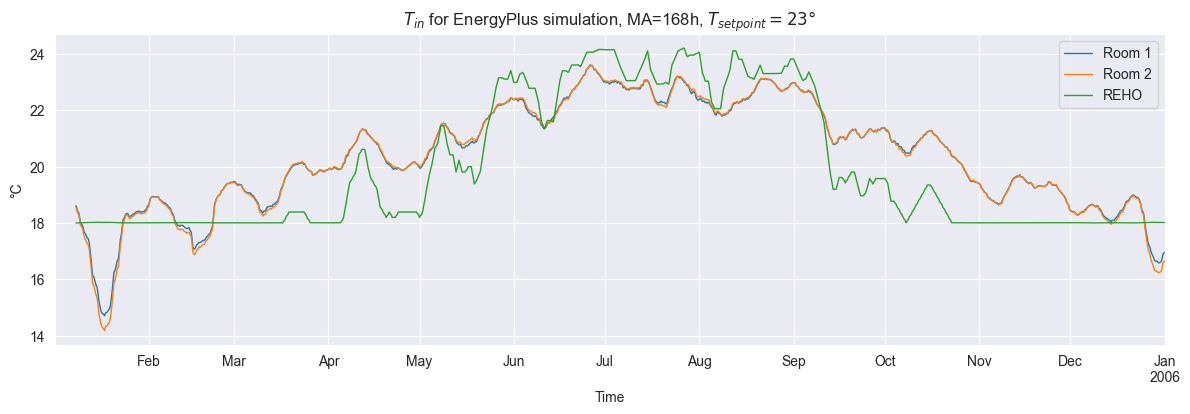

In [479]:
T_in_eplus = eplus_results[operative_temperature]
T_in_eplus.rolling(window=168).mean().plot(kind='line', lw= 1, figsize=(12, 4))
T_in_reho.rolling(window=168).mean().plot(kind='line',lw=1)
plt.legend(["Room 1", "Room 2","REHO"])
plt.xlabel('Time')
plt.ylabel('°C')
plt.tight_layout()
plt.title('$T_{in}$ for EnergyPlus simulation, MA=168h, $T_{{setpoint}}=23°$')

plt.show()

In [480]:
rmse(T_in_eplus['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'],T_in_reho)/T_in_eplus['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'].mean()

0.09549604453009788

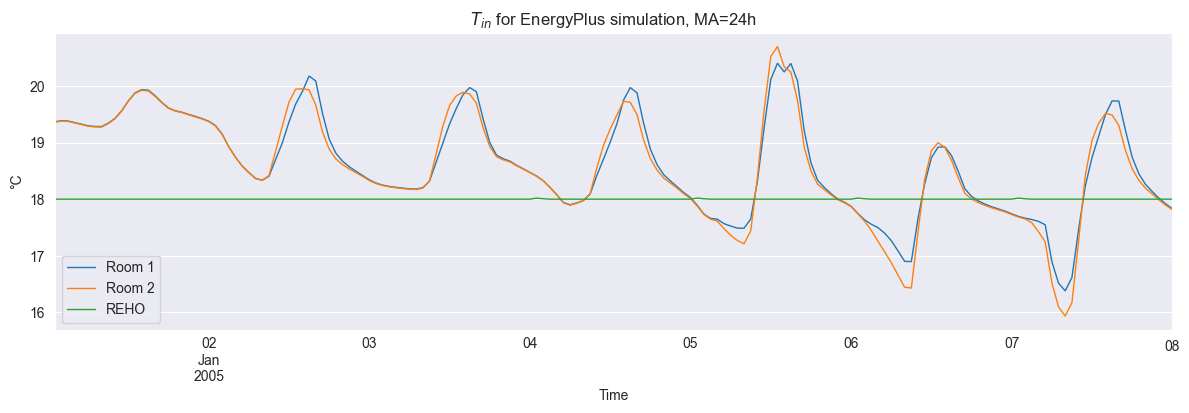

In [481]:
T_in_eplus[0:(7*24)].plot(kind='line', lw= 1, figsize=(12, 4))
T_in_reho[0:(7*24)].plot(kind='line',lw=1)
plt.legend(["Room 1", "Room 2","REHO"])
plt.xlabel('Time')
plt.ylabel('°C')
plt.tight_layout()
plt.title('$T_{in}$ for EnergyPlus simulation, MA=24h')

plt.show()

In [ ]:
# for n in range(10,20):
#     T_in_eplus.iloc[n*24:(n+1)*24].plot(kind='line', lw= 1, figsize=(12, 4))
#     T_in_reho.iloc[n*24:(n+1)*24].plot(kind='line', lw= 1)
#     plt.legend(["Room 1", "Room 2","REHO"])
#     plt.xlabel('Time')
#     plt.ylabel('°C')
#     plt.title('$T_{in}$ for EnergyPlus and REHO, zoom on a day')
#     plt.tight_layout()
#     plt.show()

## Electricity consumption

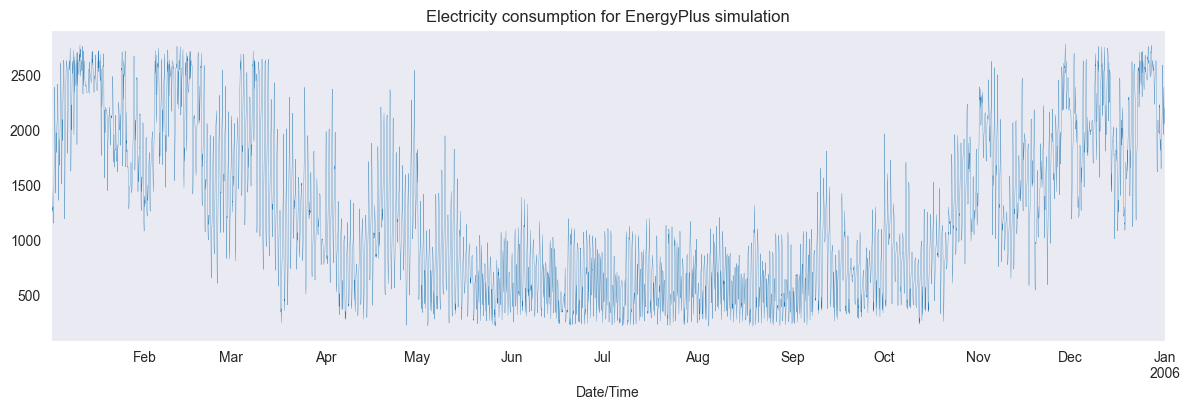

In [482]:
# Extract electricity consumption
electricity = [col for col in eplus_results.columns if 'Electricity Rate' in col]

electricity_eplus = eplus_results[electricity]

electricity_eplus.sum(axis=1).plot(kind='line', lw= 0.20, figsize=(12, 4))
plt.tight_layout()
plt.title('Electricity consumption for EnergyPlus simulation')
plt.grid()
plt.show()


In [483]:
electricity = [col for col in eplus_results.columns if 'Electric' in col]
electricity


['CELLS:ROOMX1 EQUIPMENT GAIN:Other Equipment Electricity Rate [W](Hourly)',
 'CELLS:ENTRANCE EQUIPMENT GAIN:Other Equipment Electricity Rate [W](Hourly)',
 'CELLS:ROOMX2 EQUIPMENT GAIN:Other Equipment Electricity Rate [W](Hourly)',
 'Whole Building:Facility Total Produced Electricity Energy [J](Hourly)',
 'AIR LOOP AHU EXTRACT FAN:Fan Electricity Rate [W](Hourly)',
 'AIR LOOP AHU SUPPLY FAN:Fan Electricity Rate [W](Hourly)',
 'CELLS:ROOMX1 VRF INDOOR UNIT SUPPLY FAN:Fan Electricity Rate [W](Hourly)',
 'CELLS:ENTRANCE VRF INDOOR UNIT SUPPLY FAN:Fan Electricity Rate [W](Hourly)',
 'CELLS:ROOMX2 VRF INDOOR UNIT SUPPLY FAN:Fan Electricity Rate [W](Hourly)',
 'CELLS:ROOMX1 VRF INDOOR UNIT:Zone VRF Air Terminal Cooling Electricity Rate [W](Hourly)',
 'CELLS:ROOMX1 VRF INDOOR UNIT:Zone VRF Air Terminal Heating Electricity Rate [W](Hourly)',
 'CELLS:ENTRANCE VRF INDOOR UNIT:Zone VRF Air Terminal Cooling Electricity Rate [W](Hourly)',
 'CELLS:ENTRANCE VRF INDOOR UNIT:Zone VRF Air Terminal Heat

<Axes: xlabel='Period,Time'>

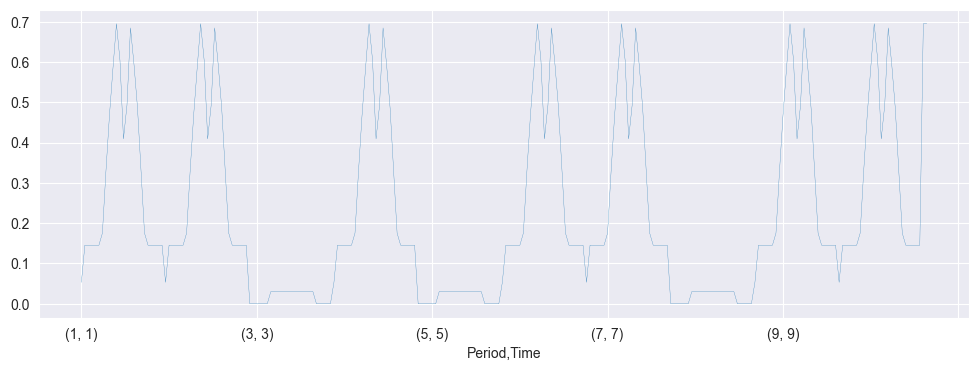

In [484]:
reho_model.results["totex"][0]["df_Buildings_t"]['Domestic_electricity'].xs("Building1").plot(kind='line', lw= 0.20, figsize=(12, 4))